In [1]:
import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
import eleanor
import lightkurve
import matplotlib.pyplot as plt
%matplotlib inline

Load in some TOI data and select TOI.

In [2]:
df = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# save relevant columns as np arrays
IDs = df["TIC ID"].values
TOIs = df["TOI"].values
ras = df["RA"].values
decs = df["Dec"].values
epochs = df["Epoch (BJD)"].values - 2457000
periods = df["Period (days)"].values
sectors = df["Sectors"].values

In [3]:
# this_toi = '101.01'
this_toi = '1050.01'
idx = np.argwhere(np.array(TOIs,  dtype=str) == this_toi)[0,0] 
ID = IDs[idx]
epoch = epochs[idx]
period = periods[idx]
sector = sectors[idx]
print(sector)

12


Retrieve eleanor light curve and plot it.

In [4]:
star = eleanor.Source(tic=str(ID), sector=int(sector), tc=True)
data = eleanor.TargetData(star, height=13, width=13, bkg_size=31)

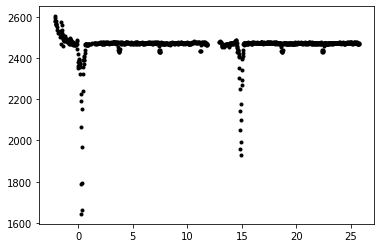

In [5]:
# restrict to data points without quality warning flags (these may be unreliable)
q = data.quality == 0
# subtract the transit epoch from time to center the transit at zero days
time = data.time[q] - epoch
flux = data.corr_flux[q]
# plot the light curve
plt.plot(time, flux, 'k.');

We need knots to use the Bspline. To get them, we'll sigma clip and mean bin every 25 points. 

Note that it's okay to use a strict sigmaclip here and clip out the transits, since we don't want the transits to influence the Bspline anyway (remember that we're only trying to correct the out-of-transit variation, so ideally each knot would be placed somewhere there isn't a transit). However, later on when we want to recover the transit, we'll want to use a less strict sigmaclip (e.g., sigma_lower=5 instead of sigma_lower=3).

In [6]:
lc = lightkurve.TessLightCurve(time, flux)
lc_binned = lc.remove_outliers(sigma_lower=3, sigma_upper=3).bin(25)
binned_time, binned_flux = lc_binned.time, lc_binned.flux

The below code will calculate the knots (t), Bspline coefficients (c), and degree of the spline (k) for you.

In [7]:
t, c, k = interpolate.splrep(binned_time, binned_flux, s=0, k=4)
print('''\
t: {}
c: {}
k: {}
'''.format(t, c, k))
N = 100
time_min, time_max = time.min(), time.max()
spline = interpolate.BSpline(t, c, k, extrapolate=False)

t: [-0.834714   -0.834714   -0.834714   -0.834714   -0.834714    1.7821017
  2.5166826   3.07272049  3.69480021  4.4479224   5.18666707  5.79291002
  6.3226971   6.86644271  7.50997979  8.20788887  8.8195498   9.36433783
  9.91683291 10.69203586 11.82494131 13.11450072 14.14861872 15.0369347
 15.81944253 16.39235084 16.94234772 17.46837401 17.99959984 18.59937923
 19.21687239 19.76809758 20.30161766 20.8328635  21.3588883  21.89469686
 22.50926682 23.11403725 23.64526305 24.17129574 25.48374245 25.48374245
 25.48374245 25.48374245 25.48374245]
c: [2476.26150921 2466.9645445  2459.81193151 2476.04608597 2471.38761343
 2476.20612146 2471.48837632 2472.83083682 2472.41154693 2472.4534417
 2474.4322944  2472.1516018  2471.15004673 2469.55744394 2473.67775535
 2472.81254808 2470.70547717 2478.2692517  2468.93041629 2461.618461
 2477.79288655 2469.39719095 2473.94729771 2473.11210555 2474.14923218
 2473.48228433 2472.53744219 2471.04550165 2469.56926239 2472.8244122
 2471.68938103 2473.20177

Calculate the Bspline interpolation and plot it.

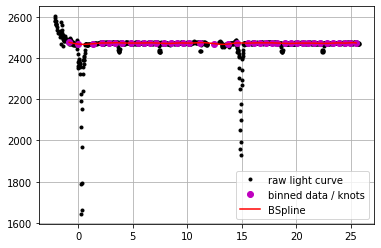

In [8]:
plt.plot(time, flux, 'k.', label='raw light curve')
plt.plot(binned_time, binned_flux, 'mo', label='binned data / knots')
plt.plot(time, spline(time), 'r', label='BSpline')
plt.grid()
plt.legend(loc='best')
plt.show()

Now flatten the light curve using the Bspline interpolation.

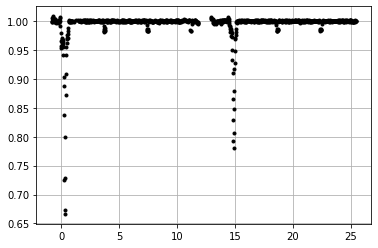

In [9]:
flattened_flux = flux/spline(time)
plt.plot(time, flattened_flux, 'k.')
plt.grid()
plt.show()

Last, plot the phase-folded light curve. Note that I sigmaclip again, but have a less strict criterion for sigma_lower, because we don't want to accidentally remove the transits from this step.

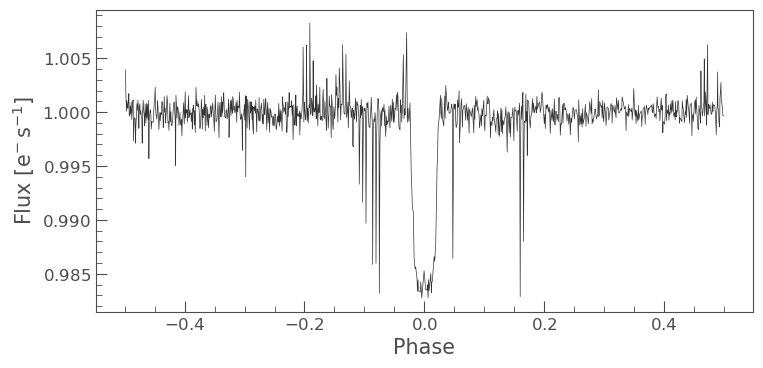

In [10]:
lc_folded = lightkurve.TessLightCurve(time, flattened_flux).remove_outliers(sigma_lower=5, sigma_upper=3).fold(period=period)
lc_folded.plot();

There are a number of ways to go from here. One option is to implement an iterative Bspline flattening routine, which might allow us to get better results for certain targets. Another option is to play with the binning/sigmaclipping at different steps in the procedure. Ideally, we want a single method that we can apply to all stars and recover a transit. 

Note that the transit doesn't have to be perfect (the example above is probably better than we need to get, on average). The most important thing is removing the long-term stellar variation without removing the transits. Project 4 is designing an algorithm to detect transits from flattened light curves that we create, so as long as there is something that resembles a periodic transit in the data we send them, they should be able to detect it.